In [1]:
import requests

#Important Libraries
from zipfile import ZipFile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

#Metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

#Data Encoding
from sklearn.preprocessing import  OneHotEncoder

#Preprocessing
from sklearn.preprocessing import StandardScaler

#Classifier
from sklearn.ensemble import RandomForestClassifier

#To create GAN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# **The three following cells loads the different datasets. Run the cell which you want to implement the modell on**

In [2]:
#Synthetic dataset
synth_train = pd.read_csv('/content/drive/MyDrive/Degree Project/train1.zip', delimiter=',')
synth_test = pd.read_csv('/content/drive/MyDrive/Degree Project/test1.zip', delimiter=',')
def data(df1,df2):
  Y1 = df1['Label'].to_numpy()                            #Labels
  Y2 = df1['Label'].to_numpy()
  X1 = df1.to_numpy()
  X2 = df2.to_numpy()
  n  = X1.shape[0]
  X = np.concatenate((X1,X2),axis=0)
  X = np.delete(X, -1, axis=1)
  X1 = X[:,[0,1,3,5]]                                    #Categorical Features
  X2 = X[:, [2,4,6]]                                     #Numerical Features
  X1 = OneHotEncoder().fit_transform(X1).toarray() #Encode categorical features
  X = np.concatenate((X1,X2), axis=1)
  X = StandardScaler().fit_transform(X)            #Standardizes data
  X = np.asarray(X).astype('float32')
  Y1 = np.asarray(Y1).astype('float32')
  Y2 = np.asarray(Y1).astype('float32')
  X1 = X[0:n]
  X2 = X[0:n]
  return X1,X2,Y1,Y2
X_train,X_test,Y_train,Y_test = data(synth_train,synth_test)
#X_train, Y_train = data(synth_train)
#X_test, Y_test = data(synth_test)

In [ ]:
#KDD-Cup 99 dataset
KDD_train = pd.read_csv('/content/drive/MyDrive/Degree Project/kddcup.data_10_percent.gz', compression='gzip').dropna() 
KDD_test = pd.read_csv('/content/drive/MyDrive/Degree Project/corrected.gz', compression='gzip').dropna()
KDD_train.columns = [
    'duration',
    'protocol_type',
    'service',
    'flag',
    'src_bytes',
    'dst_bytes',
    'land',
    'wrong_fragment',
    'urgent',
    'hot',
    'num_failed_logins',
    'logged_in',
    'num_compromised',
    'root_shell',
    'su_attempted',
    'num_root',
    'num_file_creations',
    'num_shells',
    'num_access_files',
    'num_outbound_cmds',
    'is_host_login',
    'is_guest_login',
    'count',
    'srv_count',
    'serror_rate',
    'srv_serror_rate',
    'rerror_rate',
    'srv_rerror_rate',
    'same_srv_rate',
    'diff_srv_rate',
    'srv_diff_host_rate',
    'dst_host_count',
    'dst_host_srv_count',
    'dst_host_same_srv_rate',
    'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate',
    'dst_host_srv_serror_rate',
    'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate',
    'outcome'
]

KDD_test.columns = KDD_train.columns
#Remove duplicates
KDD_train = KDD_train.drop_duplicates(keep=False)
KDD_test = KDD_test.drop_duplicates(keep=False)
#Change outcome to 0 if normal and 1 if anomalous
KDD_train['outcome'] = (KDD_train['outcome']!='normal.')*1
KDD_test['outcome'] = (KDD_test['outcome']!='normal.')*1
def data(df):
  X = df.to_numpy()
  Y = X[:,-1]
  X = np.delete(X, -1, axis=1)
  X1 = np.array([X[:,0]]).transpose()
  X2 = OneHotEncoder().fit_transform(X[:,1:2]).toarray()
  X3 = X[:,4:]
  X = np.concatenate((X1,X2,X3), axis=1)
  X = np.asarray(X).astype('float32')
  Y = np.asarray(Y).astype('float32')
  X = StandardScaler().fit_transform(X)
  normal_indx = np.where(Y==0)                      #Index of normal observations
  anomaly_indx = np.where(Y==1)                     #Index of anomalies
  X_normal  = X[normal_indx]
  X_anomaly = X[anomaly_indx]
  Y_normal  = Y[normal_indx]
  Y_anomaly = Y[anomaly_indx]
  return X,X_normal,X_anomaly,Y,Y_normal,Y_anomaly

X_train,X_normal_train,X_anomaly_train,Y_train,Y_normal_train,Y_anomaly_train = data(KDD_train)
X_test,X_normal_test,X_anomaly_test,Y_test,Y_normal_test,Y_anomaly_test       = data(KDD_test) 

In [ ]:
#Random Forest
#Optimizing hyperparameters
for n in [10,25,50,75,100]:
  for d in [2,4,8,10]:
    RandomForest = RandomForestClassifier(n_estimators = n,
                                          max_depth = d,
                                          criterion = 'gini',
                                          class_weight = 'balanced_subsample'
                                          )
    RandomForest.fit(X_train, Y_train)
    y_pred = RandomForest.predict(X_test)
    print(confusion_matrix(Y_test,y_pred), 'F_1={}'.format(f1_score(Y_test,y_pred)),'#Estimators={}'.format(n),'Max depth={}'.format(d), '\n')
  print('----------------------------------------------------------')


In [ ]:
class GAN(keras.Model):
  def __init__(self,data_dim=34 ,latent_dim=20, init_kernel=keras.initializers.GlorotNormal, init_bias=keras.initializers.constant(0)):
    super(GAN, self).__init__()
    self.data_dim      = data_dim              #Dimension of data
    self.latent_dim    = latent_dim            #Dimension of latent space
    self.init_kernel   = init_kernel           #Inititialization of weights
    self.init_bias     = init_bias             #Inititialization of bias
    self.generator     = self.Generator()
    self.discriminator = self.Discriminator()

  def Generator(self):
    generator_input  = keras.Input(self.latent_dim, name='z') #z
    generator        = layers.Dense(128, activation='relu', kernel_initializer=self.init_kernel, bias_initializer=self.init_bias)(generator_input)
    generator        = layers.Dense(256, activation='relu', kernel_initializer=self.init_kernel, bias_initializer=self.init_bias)(generator)
    generator        = layers.Dense(128, activation='relu', kernel_initializer=self.init_kernel, bias_initializer=self.init_bias)(generator)
    generator_output = layers.Dense(self.data_dim, activation='linear', kernel_initializer=self.init_kernel, bias_initializer=self.init_bias)(generator) #G(z)
    return keras.Model(generator_input, generator_output, name='Generator')

  def Discriminator(self):
    D_input  = keras.Input(self.generator.output.shape[1])
    D  = layers.Dense(128, activation='relu', kernel_initializer=self.init_kernel, bias_initializer=self.init_bias)(D_input)
    D  = layers.Dense(256, activation='relu', kernel_initializer=self.init_kernel, bias_initializer=self.init_bias)(D)
    D  = layers.Dense(128, activation='relu', kernel_initializer=self.init_kernel, bias_initializer=self.init_bias)(D)
    D  = layers.Dense(64, activation='relu', kernel_initializer=self.init_kernel, bias_initializer=self.init_bias)(D)
    D_output = layers.Dense(1, activation='sigmoid', kernel_initializer=self.init_kernel, bias_initializer=self.init_bias)(D)
    return keras.Model(D_input, D_output, name='Discriminator')

  def compile(self,optimizer = keras.optimizers.Adam(learning_rate=10**-5, beta_1=0.5), loss = keras.losses.BinaryCrossentropy(), train_metric = keras.metrics.BinaryCrossentropy):
    self.optimizer    = optimizer
    self.loss         = loss

  def train(self,X_train,Epochs=50,batch_size=128):
      for Epoch in range(Epochs):
        X = tf.data.Dataset.from_tensor_slices(X_train)
        X = X.shuffle(buffer_size=1024).batch(batch_size) #Shuffles data and divides the dataset in batches
        pbar = tqdm(X, position=0, leave=True)            #Progressbar
        for step, x in enumerate(pbar):
          z = tf.random.normal(shape=(x.shape[0], self.latent_dim))     #Sample normal distributed noise
          with tf.GradientTape(persistent=True) as tape:
            x_ = self.generator(z)                                      #Generate x from noise              
            real_pred = self.discriminator(x)
            fake_pred = self.discriminator(x_)
            d_loss = self.loss(tf.ones_like(real_pred), real_pred)+self.loss(tf.zeros_like(fake_pred), fake_pred) #Discriminator loss
            g_loss = self.loss(tf.ones_like(fake_pred), fake_pred) #Generator loss
          
          d_gradients = tape.gradient(d_loss, self.discriminator.trainable_weights)               #Discriminator gradients
          self.optimizer.apply_gradients(zip(d_gradients, self.discriminator.trainable_weights))  #Update Discriminator paramaters
          g_gradients = tape.gradient(g_loss, self.generator.trainable_weights)                   #Generator & Encoder loss
          self.optimizer.apply_gradients(zip(g_gradients, self.generator.trainable_weights))      #Update Generator and Encoder parameters
          del tape

          #Update progressbar
          if step % 100 == 0:
            pbar.set_description('Epoch %d of %d | D_loss=%.4f | G_loss=%.4f' % (Epoch+1, Epochs, d_loss, g_loss))
  
  def sample(self,N):
    z = tf.random.normal(shape=(N, self.latent_dim))     #Sample normal distributed noise
    x_ = self.generator(z)                               #Generate synthetic x from noise
    return x_

In [ ]:
#Train the GAN
GAN_sample = GAN(data_dim=X_train.shape[1])
GAN_sample.compile()
GAN_sample.train(X_anomaly_train,Epochs=20,batch_size=180)

Epoch 1 of 20 | D_loss=1.0603 | G_loss=0.6945: 100%|██████████| 226/226 [00:09<00:00, 23.39it/s]
Epoch 2 of 20 | D_loss=0.8885 | G_loss=0.7883: 100%|██████████| 226/226 [00:09<00:00, 23.43it/s]
Epoch 3 of 20 | D_loss=0.6377 | G_loss=1.0048: 100%|██████████| 226/226 [00:10<00:00, 22.08it/s]
Epoch 4 of 20 | D_loss=0.4708 | G_loss=1.2269: 100%|██████████| 226/226 [00:10<00:00, 22.08it/s]
Epoch 5 of 20 | D_loss=0.3943 | G_loss=1.3495: 100%|██████████| 226/226 [00:10<00:00, 22.09it/s]
Epoch 6 of 20 | D_loss=0.3903 | G_loss=1.2786: 100%|██████████| 226/226 [00:10<00:00, 22.09it/s]
Epoch 7 of 20 | D_loss=0.3923 | G_loss=1.2520: 100%|██████████| 226/226 [00:10<00:00, 22.08it/s]
Epoch 8 of 20 | D_loss=0.4331 | G_loss=1.1590: 100%|██████████| 226/226 [00:10<00:00, 22.08it/s]
Epoch 9 of 20 | D_loss=0.4164 | G_loss=1.1696: 100%|██████████| 226/226 [00:09<00:00, 23.74it/s]
Epoch 10 of 20 | D_loss=0.4474 | G_loss=1.0890: 100%|██████████| 226/226 [00:10<00:00, 22.09it/s]
Epoch 11 of 20 | D_loss=0.440

In [ ]:
#Sample synthetic x with the generator network
X_ = GAN_sample.sample(X_normal_train.shape[0]-X_anomaly_train.shape[0])
X = np.concatenate((X_train,X_),axis=0)
Y_ = np.ones(X_normal_train.shape[0]-X_anomaly_train.shape[0])
Y = np.concatenate((Y_train,Y_),axis=0)

In [ ]:
print(np.sum(Y))

85595.0


In [5]:
#Optimal Random Forest
RandomForest = RandomForestClassifier(n_estimators = 100,
                                          max_depth = 8,
                                          criterion = 'gini'
                                          )
RandomForest.fit(X, Y)
scores = RandomForest.predict_proba(X_test)

In [7]:
#Evaluate scores
def evaluate(Y_real, scores, Dataset='Synthetic'): #Dataset is 
  #Distribution of scores
  plt.figure()
  plt.hist(scores, bins=50)
  plt.xlabel("Anomaly score")
  plt.ylabel("No of examples")
  #plt.title('Distribution of anomaly scores')
  plt.show()
  #PPrecision-Recall curve
  precision, recall, thresholds = precision_recall_curve(Y_real, scores)
  auc_precision_recall = auc(recall, precision)
  indx = np.where(precision==0.)
  precision = np.delete(precision,indx)
  recall = np.delete(recall,indx)
  thresholds = np.delete(thresholds,indx)
  plt.figure()
  plt.plot(recall,precision)
  plt.xlabel("Recall")
  plt.ylabel("Precision")
  #plt.title(Dataset+' datset')
  plt.show()
  #Performance Scores
  F1_scores      = 2*precision*recall/(precision+recall)
  F1_max         = np.max(F1_scores)
  threshold_indx = np.where(F1_scores==F1_max) 
  y_pred = scores>=thresholds[threshold_indx]
  CM = confusion_matrix(Y_test,y_pred)

  TNR = CM[0,0] #True negative rate
  TPR = CM[1,1] #True positive rate
  FNR = CM[0,1] #False negative rate
  FPR = CM[1,0] #False positive rate

  #Table of performance metrics
  data = {'AUC_precision_recall': [auc_precision_recall], 'F1': [F1_max], 'TNR': [TNR], 'TPR': [TPR], 'FNR': [FNR], 'FPR': [FPR]}
  performance = pd.DataFrame(data, columns=['AUC_precision_recall', 'F1', 'TNR', 'TPR', 'FNR', 'FPR'], index=[Dataset])
  display(performance)
  return performance

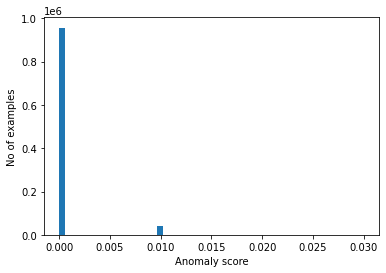

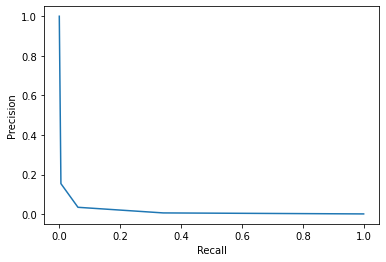

,AUC_precision_recall,F1,TNR,TPR,FNR,FPR
Synthetic,0.016103,0.043935,998702,46,1298,704


In [8]:
table = evaluate(Y_test, scores[:,1],Dataset='Synthetic')

In [ ]:
print(table.to_latex(index=True, multirow=True))

\begin{tabular}{lrrrrrr}
\toprule
{} &  AUC\_precision\_recall &        F1 &    TNR &    TPR &  FNR &   FPR \\
\midrule
Synthetic &              0.960983 &  0.879043 &  46803 &  15396 &  422 &  3815 \\
\bottomrule
\end{tabular}

